<a href="https://colab.research.google.com/github/aya-bani/changing-optimization-function/blob/main/changing_optimization_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np, pandas as pd, tensorflow as tf, random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def set_seeds(seed=42):
    np.random.seed(seed); random.seed(seed); tf.random.set_seed(seed)

In [4]:
data = pd.read_csv("/content/drive/MyDrive/projet mit/data.csv", encoding="latin1")
X = data[["Tf_in","Ua","Uw"]].values
y = data["Y"].values.reshape(-1,1)

scaler_X = MinMaxScaler()
Xs = scaler_X.fit_transform(X)

In [5]:
scaler_y = MinMaxScaler(feature_range=(0.2, 0.8))
ys = scaler_y.fit_transform(y)

X_train, X_temp, y_train, y_temp = train_test_split(Xs, ys, test_size=0.30, random_state=42)
X_val,   X_test, y_val,   y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

In [6]:
def build_model_opt(layers, hidden_act="sigmoid", out_act="sigmoid", optimizer="adam", lr=0.001):
    model = Sequential()
    model.add(Input(shape=(3,)))
    model.add(Dense(layers[0], activation=hidden_act))
    for n in layers[1:]:
        model.add(Dense(n, activation=hidden_act))
    model.add(Dense(1, activation=out_act))

    # Choose optimizer
    if optimizer == "adam":
        opt = Adam(learning_rate=lr)
    elif optimizer == "rmsprop":
        opt = RMSprop(learning_rate=lr)
    elif optimizer == "sgd":
        opt = SGD(learning_rate=lr, momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(optimizer=opt, loss="mse", metrics=["mae"])
    return model

In [7]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X, verbose=0)
    y_true = scaler_y.inverse_transform(y)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    return (
        mean_squared_error(y_true, y_pred_inv),
        mean_absolute_error(y_true, y_pred_inv),
        r2_score(y_true, y_pred_inv)
    )

In [8]:
def sweep_optims(layers=[10,5], acts="sigmoid"):
    results = []
    for opt in ["adam","rmsprop","sgd"]:
        for lr in [0.01, 0.001, 0.0005, 0.0001]:
            set_seeds(42); K.clear_session()
            model = build_model_opt(layers, hidden_act=acts, out_act="sigmoid", optimizer=opt, lr=lr)

            es = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
            hist = model.fit(X_train, y_train,
                             validation_data=(X_val, y_val),
                             epochs=1000, batch_size=8, verbose=0,
                             callbacks=[es])

            tr = evaluate_model(model, X_train, y_train)
            va = evaluate_model(model, X_val, y_val)
            te = evaluate_model(model, X_test, y_test)

            results.append({
                "optimizer": opt,
                "lr": lr,
                "train_r2": tr[2], "val_r2": va[2], "test_r2": te[2],
                "val_mse": va[0], "test_mse": te[0],
                "val_mae": va[1], "test_mae": te[1],
                "epochs_used": len(hist.history["loss"])
            })
    return pd.DataFrame(results)


In [9]:
opt_results = sweep_optims(layers=[10,5], acts="sigmoid")
print("\n=== Optimizer + LR Results (Top 5 by Test R²) ===")
print(opt_results.sort_values("test_r2", ascending=False).head())


=== Optimizer + LR Results (Top 5 by Test R²) ===
  optimizer      lr  train_r2    val_r2   test_r2   val_mse  test_mse  \
0      adam  0.0100  0.892984  0.595818  0.892887  0.011851  0.003357   
1      adam  0.0010  0.857275  0.562207  0.889160  0.012836  0.003474   
5   rmsprop  0.0010  0.838649  0.553779  0.846640  0.013083  0.004806   
2      adam  0.0005  0.831945  0.550189  0.829381  0.013189  0.005347   
4   rmsprop  0.0100  0.786522  0.607053  0.827627  0.011521  0.005402   

    val_mae  test_mae  epochs_used  
0  0.075245  0.049982          274  
1  0.075279  0.049921         1000  
5  0.075041  0.057287          661  
2  0.074687  0.060492         1000  
4  0.074648  0.063802           79  


  optimizer      lr  train_r2    val_r2   test_r2   val_mse  test_mse  \
0      adam  0.0100  0.892984  0.595818  0.892887  0.011851  0.003357   
1      adam  0.0010  0.857275  0.562207  0.889160  0.012836  0.003474   
5   rmsprop  0.0010  0.838649  0.553779  0.846640  0.013083  0.004806   
2      adam  0.0005  0.831945  0.550189  0.829381  0.013189  0.005347   
4   rmsprop  0.0100  0.786522  0.607053  0.827627  0.011521  0.005402   

    val_mae  test_mae  epochs_used  
0  0.075245  0.049982          274  
1  0.075279  0.049921         1000  
5  0.075041  0.057287          661  
2  0.074687  0.060492         1000  
4  0.074648  0.063802           79  


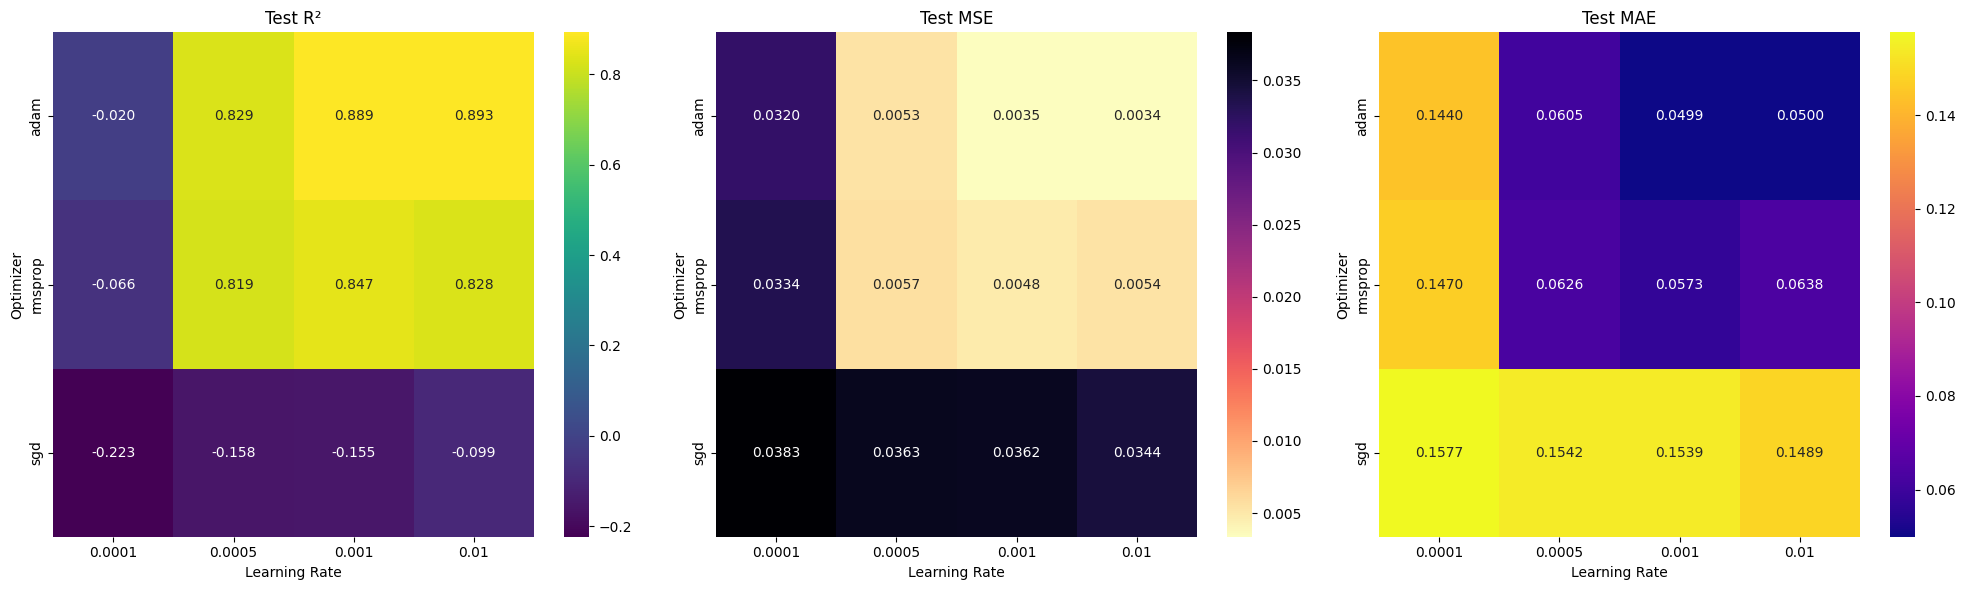

In [15]:
# Run optimization sweep
opt_results = sweep_optims(layers=[10,5], acts="sigmoid")
print(opt_results.sort_values("test_r2", ascending=False).head())

# -----------------------------
# Heatmaps for R², MSE, MAE
# -----------------------------
pivot_r2  = opt_results.pivot(index="optimizer", columns="lr", values="test_r2")
pivot_mse = opt_results.pivot(index="optimizer", columns="lr", values="test_mse")
pivot_mae = opt_results.pivot(index="optimizer", columns="lr", values="test_mae")

fig, axes = plt.subplots(1, 3, figsize=(20,6))

sns.heatmap(pivot_r2, annot=True, fmt=".3f", cmap="viridis", ax=axes[0])
axes[0].set_title("Test R²")
axes[0].set_ylabel("Optimizer")
axes[0].set_xlabel("Learning Rate")

sns.heatmap(pivot_mse, annot=True, fmt=".4f", cmap="magma_r", ax=axes[1])
axes[1].set_title("Test MSE")
axes[1].set_ylabel("Optimizer")
axes[1].set_xlabel("Learning Rate")

sns.heatmap(pivot_mae, annot=True, fmt=".4f", cmap="plasma", ax=axes[2])
axes[2].set_title("Test MAE")
axes[2].set_ylabel("Optimizer")
axes[2].set_xlabel("Learning Rate")

plt.tight_layout()
plt.show()


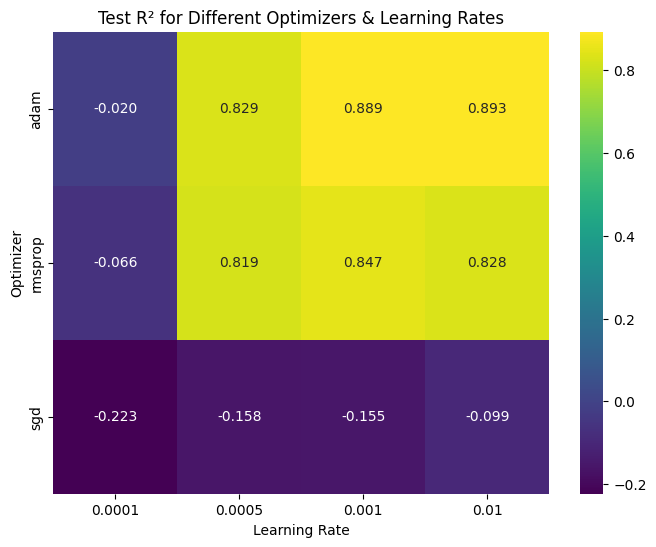

In [14]:
# -----------------------------
# Heatmap for visualization
# -----------------------------
pivot = opt_results.pivot(index="optimizer", columns="lr", values="test_r2")

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Test R² for Different Optimizers & Learning Rates")
plt.ylabel("Optimizer")
plt.xlabel("Learning Rate")
plt.show()
